# Alzheimer's Disease and the Frontal Lobe
### Introduction to Computational Medicine I:  Imaging

Adam Kenet, Chenyu Gao, Zixuan Wang, Shardul Rakshit

October 2020


### Content:
- ADNI dataset
    - Data Cleaning
    - Characterization of the dataset
        - Butterfly Plot
        - Pie Charts
        - Violin Plots
        - Box Plots
    - Statistics
        - z-score barcodes
        - H1: Control vs. Alzheimer's? (t-test)
        - H2: Volume vs. Age? (linear regression)

- MRICloud Data
    - Comparison with ADNI dataset
        - z-score Barcodes
        - Bar Plot

## ADNI dataset
### Part 1: Data Cleaning

In [1]:
# import modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

from tqdm import tqdm
from scipy import stats 
#from scipy.stats import zscore

import matplotlib as mpl

# set plot properties
%matplotlib inline
mpl.rcParams['font.size'] = 14

In [2]:
# read the ADNI data
dat_all = pd.read_excel('ADNI_ICM_random200.xlsx')
dat_all = dat_all.replace({'\'':''}, regex=True) # remove ' ' from data
dat_all = dat_all.rename(columns=lambda x:x.strip('\'')) # remove ' ' from column names
dat_all.index += 1 # change index to start at 1
#dat_all

In [3]:
# select only the columns of interest
rois = ['IFG_opercularis_L','IFG_orbitalis_L','IFG_triangularis_L','LFOG_L','MFG_L','MFOG_L','PrCG_L','SFG_L',
       'IFG_opercularis_R','IFG_orbitalis_R','IFG_triangularis_R','LFOG_R','MFG_R','MFOG_R','PrCG_R','SFG_R']
info = ['Subject_ID', 'Gender', 'Age', 'Diagnosis']
columns = np.concatenate((info, rois), axis=0)
dat = dat_all[columns]
#dat

In [4]:
# split into Alzheimer's group and control group
ad = dat[dat.Diagnosis == 'AD/MCI']
control = dat[dat.Diagnosis == 'NORMAL']

# spilt by gender
ad_female = ad[ad.Gender == 'F']
ad_male = ad[ad.Gender == 'M']
control_male = control[control.Gender == 'M']
control_female = control[control.Gender == 'F']

In [5]:
#ad

In [6]:
#control.describe()

### Part 2: Characterization of the ADNI Dataset
- Butterfly Plot
- Pie Charts
- Violin Plots
- Box Plots

**Butterfly Plot**

In [7]:
#determine the number of people in each age group
bin_max = 93
bin_min = 55
bin_gap = 2
hist_ad_female, bin_edges = np.histogram(ad[ad.Gender == 'F']['Age'],bins=np.arange(bin_min,bin_max,bin_gap))
hist_ad_male, bin_edges = np.histogram(ad[ad.Gender == 'M']['Age'],bins=np.arange(bin_min,bin_max,bin_gap))
hist_control_female, bin_edges = np.histogram(control[control.Gender == 'F']['Age'],bins=np.arange(bin_min,bin_max,bin_gap))
hist_control_male, bin_edges = np.histogram(control[control.Gender == 'M']['Age'],bins=np.arange(bin_min,bin_max,bin_gap))

AgeGroup = [] #create a list of age group, strings
for i in bin_edges:
    if i == bin_max - bin_gap: break
    AgeGroup.append(str(i)+ '-' +str(i+bin_gap))

#create a dataframe for plotting
d_gender_diagnosis = {'AgeGroup':AgeGroup,
     'AD_Female':hist_ad_female,
     'AD_Male':hist_ad_male,
     'Control_Female':hist_control_female * -1,
     'Control_Male':hist_control_male *-1}
df_gender_diagnosis = pd.DataFrame(data=d_gender_diagnosis)
df_gender_diagnosis['AD_Tot'] = df_gender_diagnosis['AD_Male'] + df_gender_diagnosis['AD_Female']
df_gender_diagnosis['Control_Tot'] = df_gender_diagnosis['Control_Male'] + df_gender_diagnosis['Control_Female'] 
#df_gender_diagnosis.info()
df_gender_diagnosis_rev = df_gender_diagnosis[::-1] #for plotting

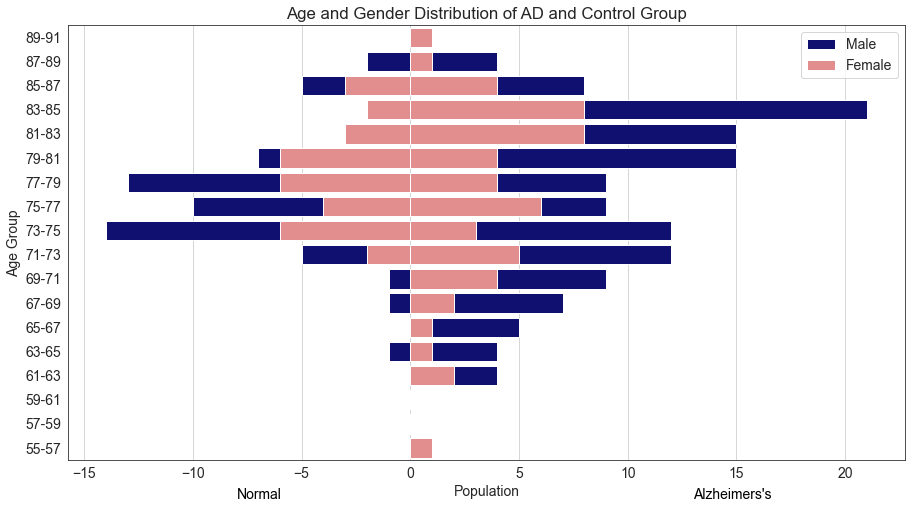

In [8]:
sns.set_style("white")
plt.figure(figsize=(15,8))

bar_plot = sns.barplot(x="AD_Tot",y="AgeGroup", color="navy", label="Male",data = df_gender_diagnosis_rev)
bar_plot = sns.barplot(x="Control_Tot",y="AgeGroup", color="navy", data = df_gender_diagnosis_rev)
bar_plot = sns.barplot(x="AD_Female",y="AgeGroup", color='lightcoral', label="Female",data = df_gender_diagnosis_rev)
bar_plot = sns.barplot(x="Control_Female",y="AgeGroup", color="lightcoral", data = df_gender_diagnosis_rev)

# Labels 
bar_plot.set(xlabel="Population", ylabel="Age Group", title = "Age and Gender Distribution of AD and Control Group");
bar_plot.xaxis.grid(True)
plt.text(-8,19.1,'Normal',fontdict={'size':'14','color':'black'})
plt.text(13,19.1,"Alzheimers's",fontdict={'size':'14','color':'black'})
plt.legend();

**Pie Charts**

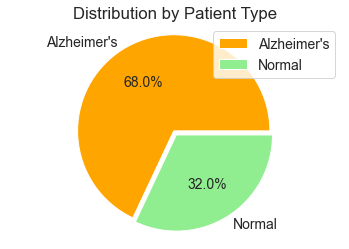

In [9]:
# Distribution for AD & control group

# print("Number of AD patients:", len(ad)) #136
# print("Number of Normal patients:", len(control)) #64

labels = "Alzheimer's", "Normal"
sizes = [68, 32]

explode = (0, 0.05)

plt.pie(sizes, explode = explode, labels = labels, colors = ['orange','lightgreen'], autopct ='%1.1f%%')
plt.title('Distribution by Patient Type')

plt.axis('equal')
plt.legend()
plt.show()

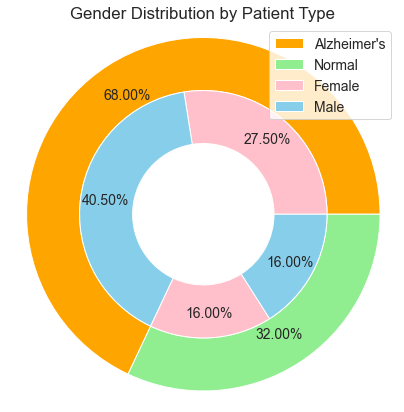

In [10]:
# Gender Distribution
size = 0.3
vals = np.array([[55.,81.],[32.,32.]])

plt.figure(figsize=(7,7),dpi=72)
plt.pie(vals.sum(axis=1),radius=1,wedgeprops=dict(width=size,edgecolor='w'), colors= ['orange','lightgreen'],autopct='%.2f%%',pctdistance=0.8)

labels = "Alzheimer's", "Normal","Female", "Male"
plt.pie(vals.flatten(),radius=1-size,wedgeprops=dict(width=size,edgecolor='w'),colors= ['pink','skyblue'],autopct='%.2f%%',pctdistance=0.8)


plt.axis('equal')
plt.legend(labels=labels)
plt.title('Gender Distribution by Patient Type')
plt.show()

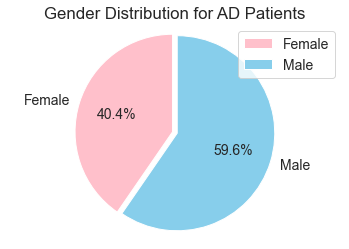

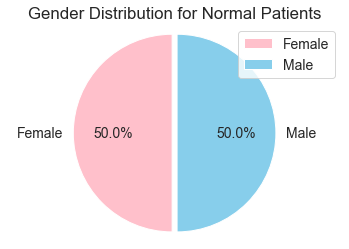

In [11]:
#plot1: Gender Distribution for AD Patients
fig1,ax1 = plt.subplots()

# print("Number of AD females:", len(ad_female)) #55
# print("Number of AD males:", len(ad_male)) #81

labels = "Female", "Male"

sizes = [40.4, 59.6]

explode = (0, 0.05)

plt.pie(sizes, explode = explode,colors = ['pink','skyblue'], labels=labels,autopct ='%1.1f%%', startangle = 90)
plt.title('Gender Distribution for AD Patients')

plt.axis('equal')
plt.legend()
plt.show()


#plot2: Gender Distribution for Normal Patients
fig2,ax2 = plt.subplots()


# print("Number of control females:", len(control_female)) #32
# print("Number of control males:", len(control_male)) #32

labels = "Female", "Male"

sizes = [50, 50]

explode = (0, 0.05)

plt.pie(sizes, explode = explode, colors = ['pink','skyblue'], autopct ='%1.1f%%',labels=labels, startangle = 90)
plt.title('Gender Distribution for Normal Patients')

plt.axis('equal')
plt.legend()
plt.show()

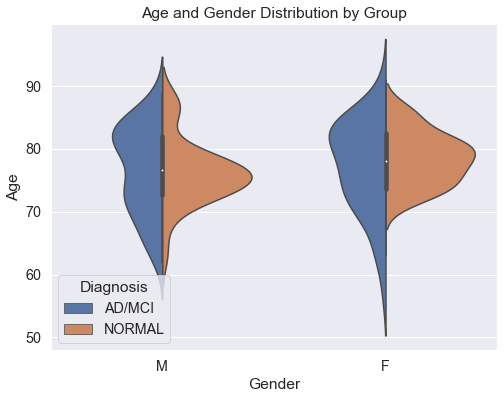

In [12]:
# Violin Plot - Gender & Age Distribution
plt.figure(figsize=(8,6),dpi=72)
sns.set(font_scale=1.3)
sns.violinplot(x = "Gender",y = "Age", hue = "Diagnosis",data=dat_all,split=True)
plt.title('Age and Gender Distribution by Group');

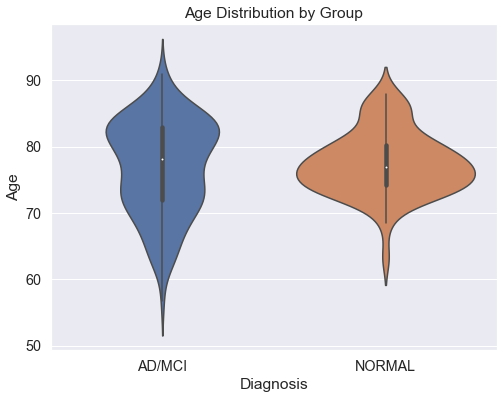

In [13]:
# Violin Plot - Age & Group Distribution
plt.figure(figsize=(8,6),dpi=72)
sns.set(font_scale=1.3)
sns.violinplot(x = "Diagnosis",y = "Age", data=dat_all)
plt.title('Age Distribution by Group');

In [14]:
# split patient info and volume data
ad_info = ad[info]
ad_volume = ad[rois]
control_info = control[info]
control_volume = control[rois]

In [15]:
ad_volume

,IFG_opercularis_L,IFG_orbitalis_L,IFG_triangularis_L,LFOG_L,MFG_L,MFOG_L,PrCG_L,SFG_L,IFG_opercularis_R,IFG_orbitalis_R,IFG_triangularis_R,LFOG_R,MFG_R,MFOG_R,PrCG_R,SFG_R
1,3398,4070,3400,4822,7828,5186,12612,11247,2923,3643,2238,4765,6578,4822,15284,9210
2,2874,4022,3388,3268,7585,3534,10988,9028,2752,2707,2937,4013,6798,4145,13123,8699
5,3775,3331,3260,4700,8987,4150,13196,10262,4290,2792,3413,4726,7612,3989,15189,8834
6,2521,2250,2047,3771,6624,3940,8950,9155,2211,1793,1959,3438,6400,3782,10720,8238
7,2515,2566,2878,3723,6152,3224,10550,9695,2615,2365,2254,3267,6384,3042,12045,7188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2967,3828,3425,4840,9173,4276,13521,11100,2714,3432,2692,4068,8380,4240,15935,8519
193,2816,3030,2605,4233,8320,4007,11802,9294,3233,2280,2519,3682,7939,4106,13835,8461
197,2698,2565,2955,4384,7249,3927,11307,10365,2573,2621,2297,3987,8237,4206,13327,7708
198,3068,3168,3530,4055,8214,3960,11887,9327,3432,2607,3524,3633,7469,4091,13808,8070


In [16]:
#control_volume

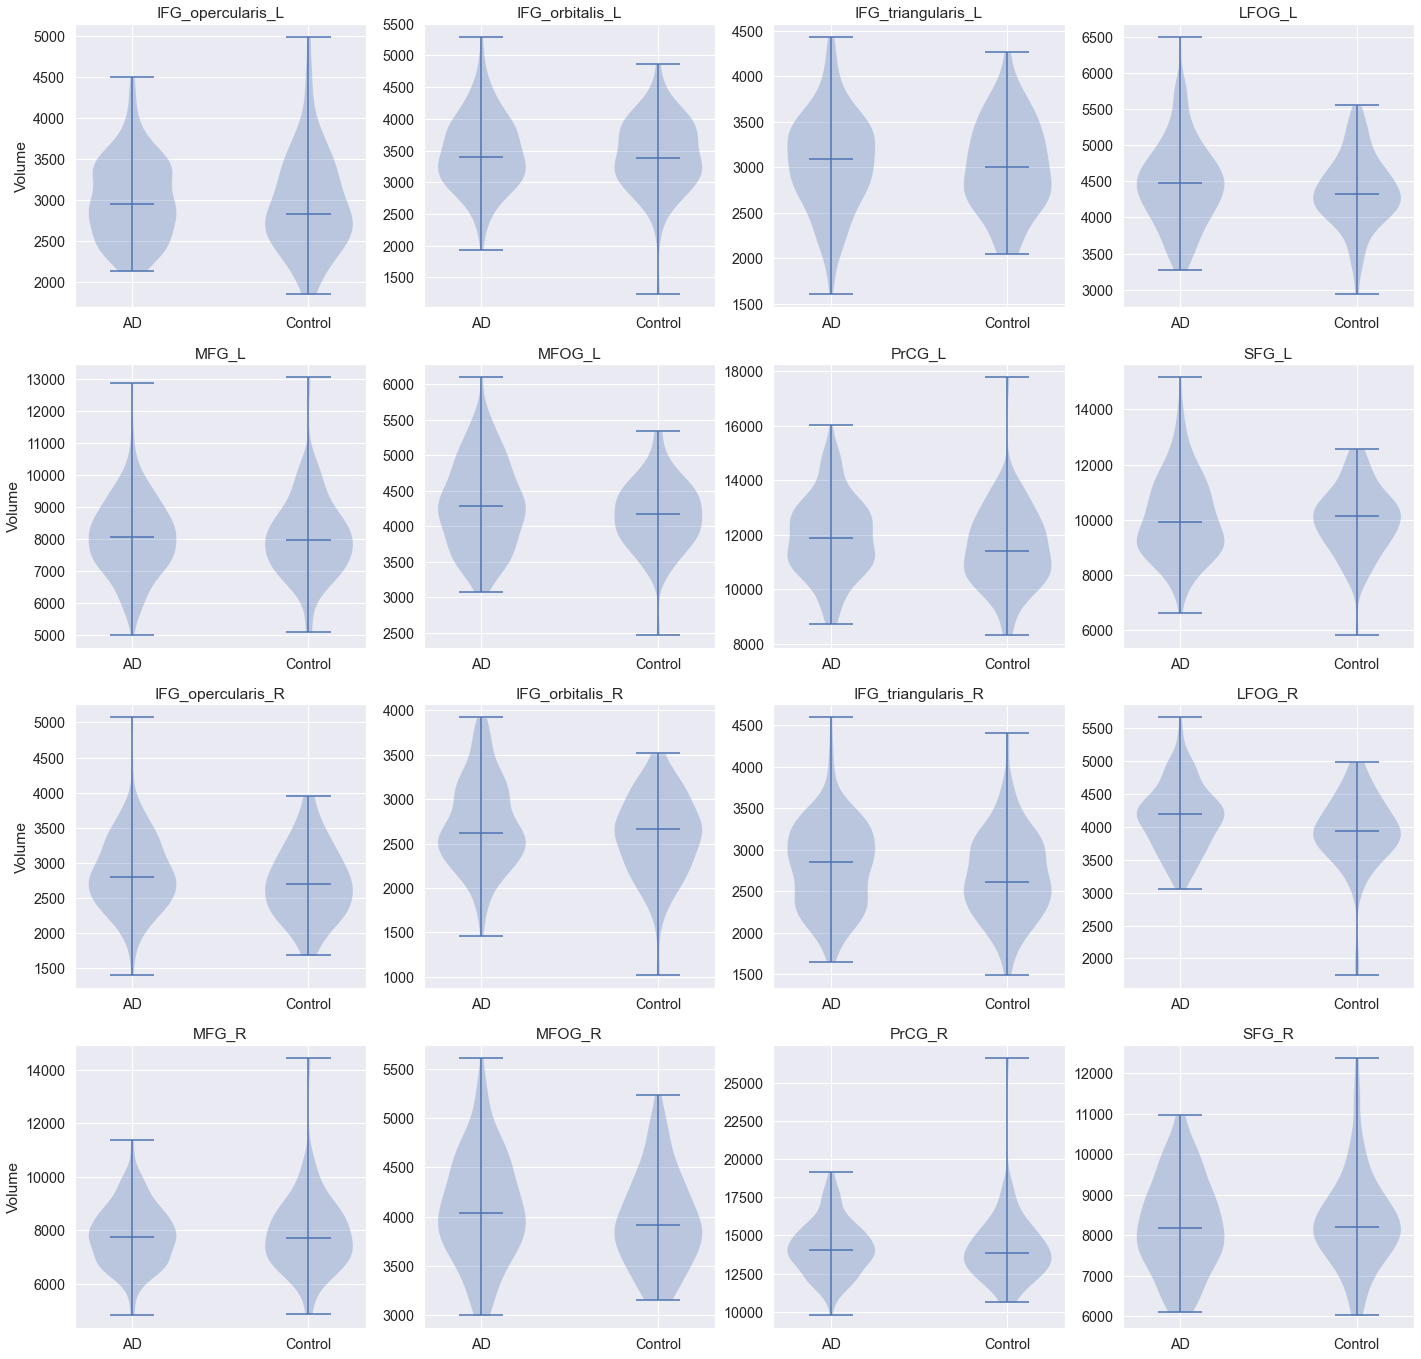

In [17]:
#violin plot to show the differences in structure volumes between AD and control group
#contact Chenyu Gao if you find anything wrong in this block

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 24))
plt.style.use('seaborn-white')

# plot violin plot
for i in range(0,16):
    compare = [ad_volume.iloc[:,i],control_volume.iloc[:,i]] #collect data from AD and control group
    axes[i//4,i%4].violinplot(compare,
                   showmeans=False,
                   showmedians=True) #loop and plot
    axes[i//4,i%4].set_title(control_volume.columns[i])
    axes[i//4,i%1].set_ylabel('Volume')
    axes[i//4,i%4].yaxis.grid(True) #add horizontal grid line

# add x-tick labels
plt.setp(axes, xticks=[1,2],
         xticklabels=['AD', 'Control'])


plt.show()

**Box Plots**

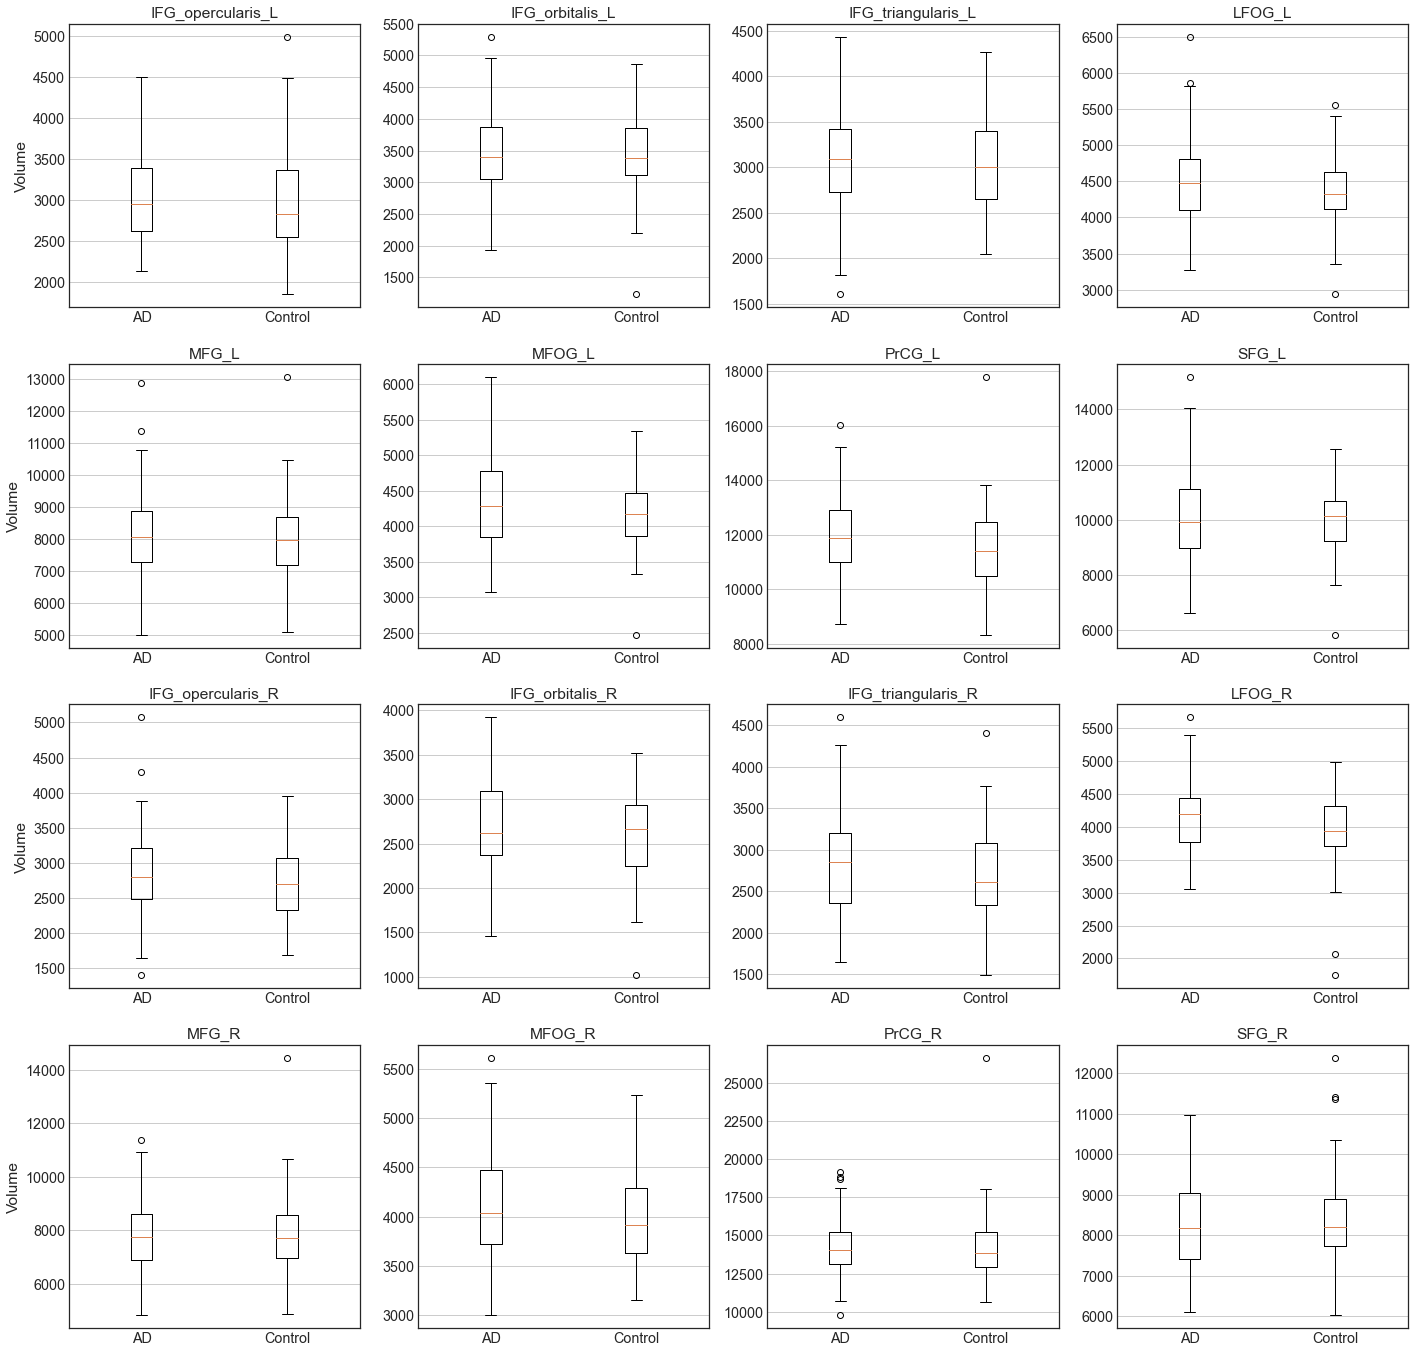

In [18]:
# box plot may look more scientific but contain less information I think
#contact Chenyu Gao if you find anything wrong in this block

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 24))

#plot box plot
for i in range(0,16):
    compare = [ad_volume.iloc[:,i],control_volume.iloc[:,i]] #collect data from AD and control group
    axes[i//4,i%4].boxplot(compare)#loop and plot
    axes[i//4,i%4].set_title(control_volume.columns[i])
    axes[i//4,i%1].set_ylabel('Volume')
    axes[i//4,i%4].yaxis.grid(True) #add horizontal grid line

# add x-tick labels
plt.setp(axes, xticks=[1,2],
         xticklabels=['AD', 'Control'])

plt.style.use('seaborn-whitegrid')
plt.show()

### Part 3: Statistics
- z-score Barcodes
- H1: Control vs. Alzheimer's? (t-test)
- H2: Volume vs. Age? (linear regression)

**z-score Barcodes**

In [19]:
# create new df with mean and standard deviation for control
control_mean = control_volume.mean()
control_std = control_volume.std()
control_mean_std = pd.DataFrame({'control_mean':control_mean, 'control_std':control_std}).T
#control_mean_std

In [20]:
# import z-score data from Excel
zscores_messy = pd.read_excel('ADNI_ICM_random200_sorted.xlsx')
zscores_messy = zscores_messy[zscores_messy.Value == 'z-score'] # only get z-score values
zscores_messy = zscores_messy.replace({'\'':''}, regex=True) # remove ' ' from data
zscores_messy = zscores_messy.rename(columns=lambda x:x.strip('\'')) # remove ' ' from column names
zscores_messy.Age = zscores_messy.Age.round(1) # round Age values
zscores = zscores_messy.replace({'Subject_':''}, regex=True).set_index('Subject_ID') # set index to patient number
#zscores

In [21]:
# separate only the AD z-scores
ad_zscore = zscores[zscores.Diagnosis == 'AD/MCI'][rois]
#ad_zscore

In [22]:
# separate only the control z-scores
control_zscore = zscores[zscores.Diagnosis == 'NORMAL'][rois]
#control_zscore

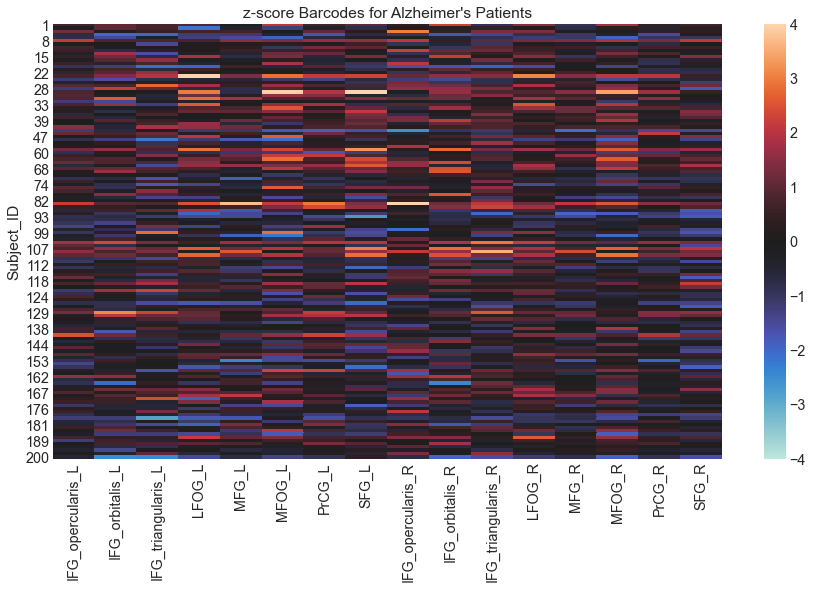

In [23]:
# heat map for all Alzheimer's patients
plt.figure(figsize=(15,8))
ax1 = sns.heatmap(ad_zscore, vmin=-4, vmax=4, center=0)
ax1.set(title = "z-score Barcodes for Alzheimer's Patients");

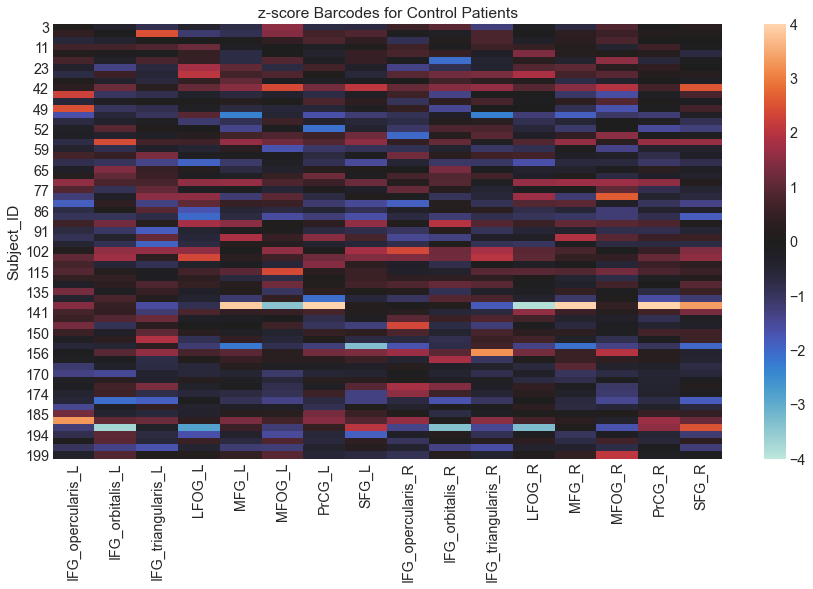

In [24]:
# heat map for all control patients
plt.figure(figsize=(15,8))
ax2 = sns.heatmap(control_zscore, vmin=-4, vmax=4, center=0)
ax2.set(title = "z-score Barcodes for Control Patients");

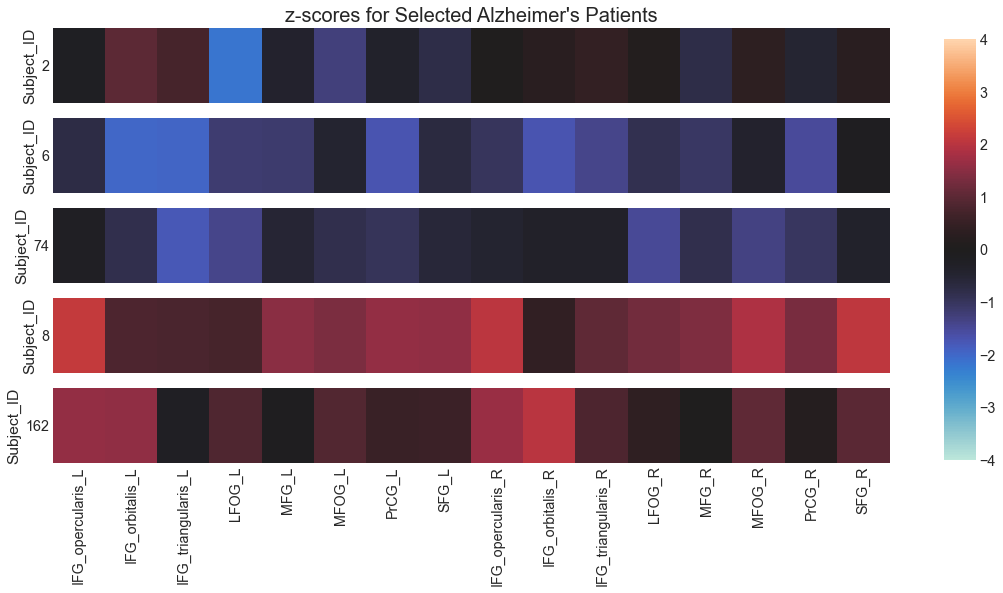

In [25]:
# selected heat maps
fig, axn = plt.subplots(5,1, figsize=(15,8))
cbar_ax = fig.add_axes([0.95, 0.13, 0.03, .73])

plt.subplot(5,1,1)
sns.heatmap(ad_zscore.iloc[1:2], xticklabels= False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)
plt.title('z-scores for Selected Alzheimer\'s Patients', fontsize=20);

plt.subplot(5,1,2)
sns.heatmap(ad_zscore.iloc[3:4], xticklabels= False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(5,1,3)
sns.heatmap(ad_zscore.iloc[50:51], xticklabels= False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(5,1,4)
sns.heatmap(ad_zscore.iloc[5:6], xticklabels= False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)

plt.subplot(5,1,5)
sns.heatmap(ad_zscore.iloc[110:111], vmin=-4, vmax=4, center=0, cbar_ax=cbar_ax)
plt.yticks(rotation=0);

In [26]:
# sort by age
age_sorted_zscores_messy = zscores_messy.sort_values(by=['Age']).set_index('Age').dropna() # set index to Age
age_sorted_zscores = age_sorted_zscores_messy[rois]
#age_sorted_zscores

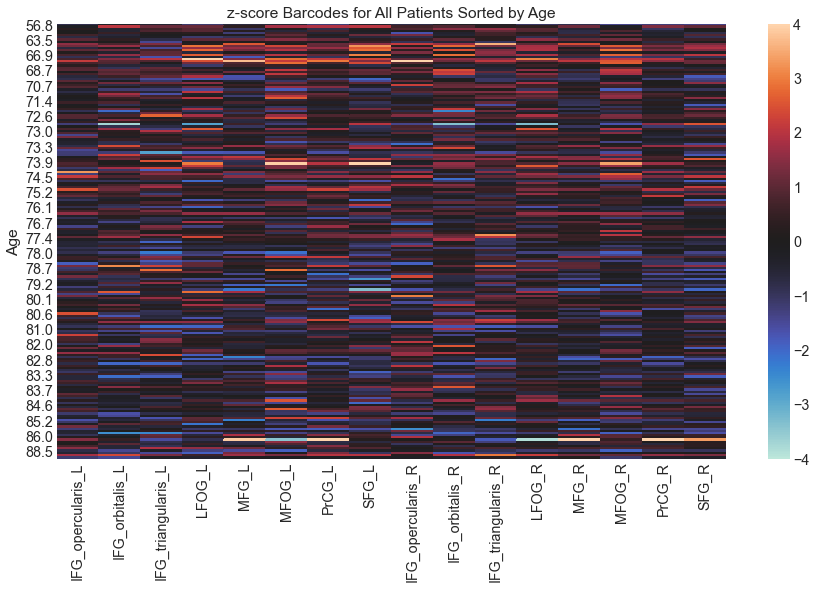

In [27]:
# heat map for all patients sorted by age
plt.figure(figsize=(15,8))
ax2 = sns.heatmap(age_sorted_zscores, vmin=-4, vmax=4, center=0)
ax2.set(title = "z-score Barcodes for All Patients Sorted by Age");

In [28]:
# sort AD group by age
age_sorted_zscores_ad = age_sorted_zscores_messy[age_sorted_zscores_messy.Diagnosis == 'AD/MCI'][rois]
#age_sorted_zscores_ad

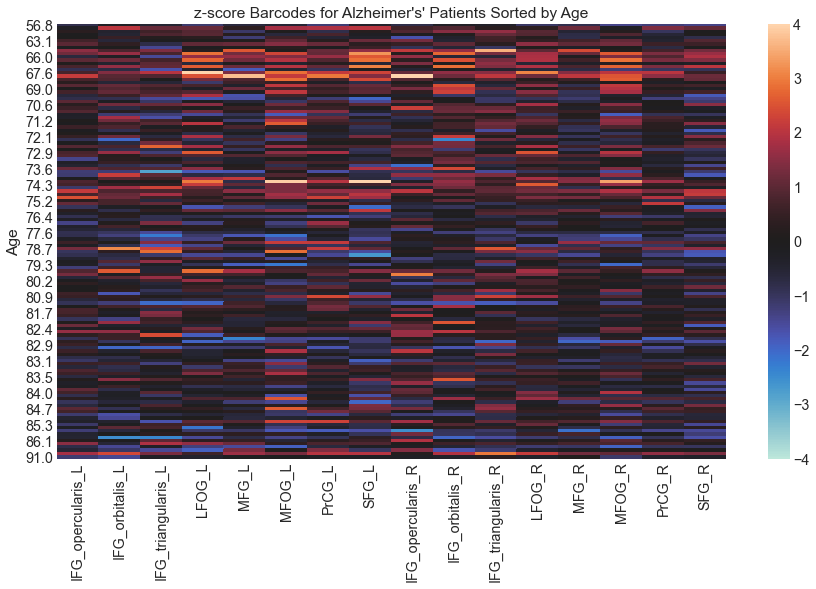

In [29]:
# heat map for AD patients sorted by age
plt.figure(figsize=(15,8))
ax2 = sns.heatmap(age_sorted_zscores_ad, vmin=-4, vmax=4, center=0)
ax2.set(title = "z-score Barcodes for Alzheimer\'s' Patients Sorted by Age");

In [30]:
# sort control group by age
age_sorted_zscores_control = age_sorted_zscores_messy[age_sorted_zscores_messy.Diagnosis == 'NORMAL'][rois]
#age_sorted_zscores_control

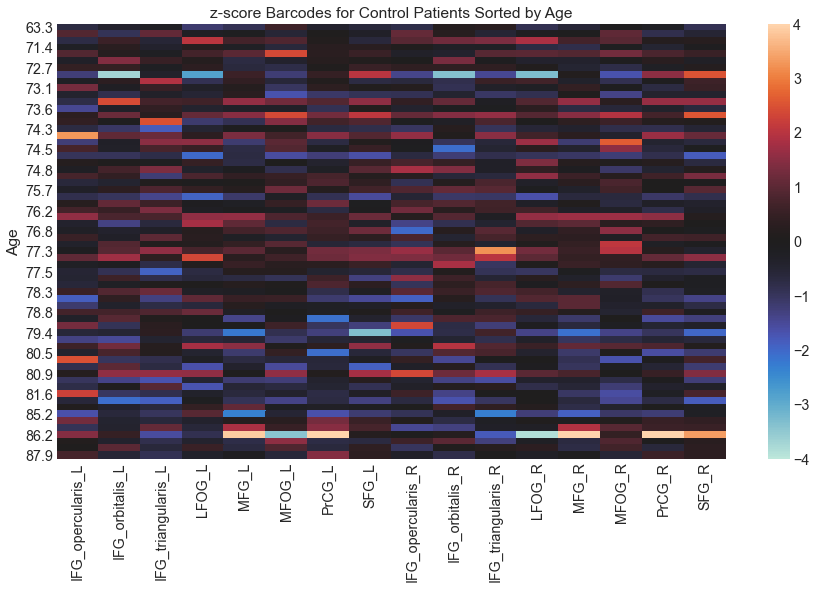

In [31]:
# heat map for all patients sorted by age
plt.figure(figsize=(15,8))
ax2 = sns.heatmap(age_sorted_zscores_control, vmin=-4, vmax=4, center=0)
ax2.set(title = "z-score Barcodes for Control Patients Sorted by Age");

**H1: Control vs. Alzheimer's? (t-test)**

In [32]:
# t-test for volumes from ADNI data (AD vs. Control)
(statistics, pvalues) = stats.ttest_ind(ad_volume, control_volume) 
#pvalues

Null Hypothesis: There is no difference in the mean volume for each region of the brain in the Frontal Lobe between the control group and the Alzheimer's group.

In [33]:
# add p-values to Dataframe with corresponding brain region and sort
df_pvals = pd.DataFrame({'p-values': pvalues}, index=rois)
df_pvals_sorted = df_pvals.sort_values(by=['p-values'])
rois_sorted = df_pvals_sorted.index # also sort lables
#df_pvals_sorted

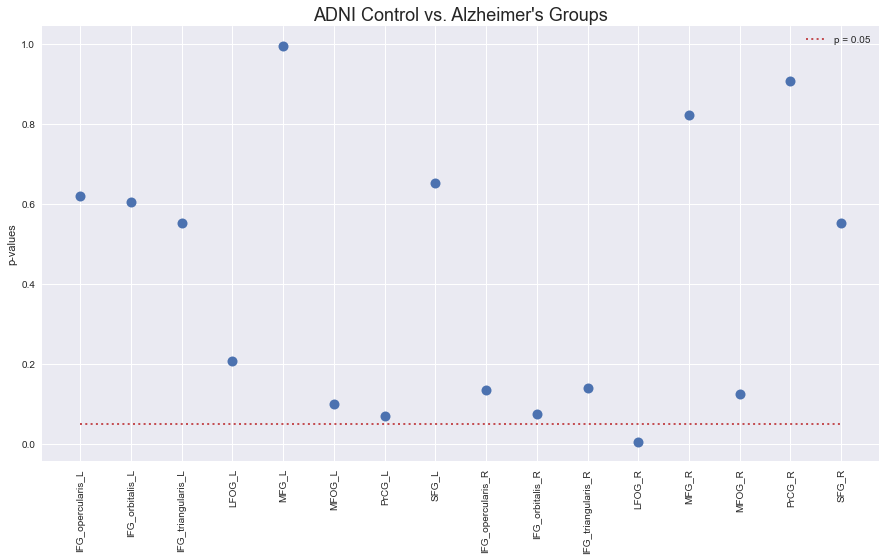

In [34]:
# plot p-values for each brain region
plt.figure(figsize=(15,8))
plt.style.use('seaborn')
plt.plot(df_pvals['p-values'],'.', label='_nolegend_', markersize=20)
plt.plot(np.arange(df_pvals.shape[0]), np.full(df_pvals.shape[0],0.05), 'r:', linewidth=2)
plt.xticks(rotation='vertical')
plt.ylabel('p-values')
plt.legend(['p = 0.05'], loc='upper right')
plt.title('ADNI Control vs. Alzheimer\'s Groups',fontsize=18);

In [35]:
full_rois = ['left inferior frontal gyrus pars opercularis',
             'left inferior frontal gyrus pars orbitralis',
             'left inferior frontal gyrus pars triangularis',
             'left lateral fronto-orbital gyrus',
             'left middle frontal gyrus (posterior segment)',
             'left middle fronto-orbital gyrus',
             'left precentral gyrus',
             'left superior frontal gyrus (posterior segment)',
             'right inferior frontal gyrus pars opercularis',
             'right inferior frontal gyrus pars orbitralis',
             'right inferior frontal gyrus pars triangularis',
             'right lateral fronto-orbital gyrus',
             'right middle frontal gyrus (posterior segment)',
             'right middle fronto-orbital gyrus',
             'right precentral gyrus',
             'right superior frontal gyrus (posterior segment)']

In [36]:
# print if result is or isn't significant
for i in range(len(pvalues)):
    if pvalues[i] < 0.05:
        print(f'There is a SIGNIFICANT difference between the average volume of the {full_rois[i]} ({rois[i]}) in the control group and Alzheimer\'s group in the ADNI dataset.\n')
    else:
        print(f'There is a NOT a significant difference between the average volume of the {full_rois[i]} ({rois[i]}) in the control group and Alzheimer\'s group in the ADNI dataset.\n')
        

There is a NOT a significant difference between the average volume of the left inferior frontal gyrus pars opercularis (IFG_opercularis_L) in the control group and Alzheimer's group in the ADNI dataset.

There is a NOT a significant difference between the average volume of the left inferior frontal gyrus pars orbitralis (IFG_orbitalis_L) in the control group and Alzheimer's group in the ADNI dataset.

There is a NOT a significant difference between the average volume of the left inferior frontal gyrus pars triangularis (IFG_triangularis_L) in the control group and Alzheimer's group in the ADNI dataset.

There is a NOT a significant difference between the average volume of the left lateral fronto-orbital gyrus (LFOG_L) in the control group and Alzheimer's group in the ADNI dataset.

There is a NOT a significant difference between the average volume of the left middle frontal gyrus (posterior segment) (MFG_L) in the control group and Alzheimer's group in the ADNI dataset.

There is a NOT

**H2: Volume vs. Age? (linear regression)**

Null Hypothesis: Age has no effect on volume.

In [37]:
#create a dataframe for this section
dat_h_age = dat.copy()
dat_h_age['Total_Frontal Lobe'] = dat_h_age[rois].sum(axis=1)
dat_h_age

,Subject_ID,Gender,Age,Diagnosis,IFG_opercularis_L,IFG_orbitalis_L,IFG_triangularis_L,LFOG_L,MFG_L,MFOG_L,...,SFG_L,IFG_opercularis_R,IFG_orbitalis_R,IFG_triangularis_R,LFOG_R,MFG_R,MFOG_R,PrCG_R,SFG_R,Total_Frontal Lobe
1,Subject_1,M,69.6712,AD/MCI,3398,4070,3400,4822,7828,5186,...,11247,2923,3643,2238,4765,6578,4822,15284,9210,102026
2,Subject_2,F,85.3836,AD/MCI,2874,4022,3388,3268,7585,3534,...,9028,2752,2707,2937,4013,6798,4145,13123,8699,89861
3,Subject_3,F,86.2904,NORMAL,3056,3199,2607,4144,7120,4932,...,9129,3048,3040,2025,3801,6914,4377,14087,8692,90600
4,Subject_4,M,73.9342,NORMAL,3231,3401,4262,3798,6933,4880,...,11068,2647,2464,3115,3940,8431,4240,14588,8519,98081
5,Subject_5,M,79.9918,AD/MCI,3775,3331,3260,4700,8987,4150,...,10262,4290,2792,3413,4726,7612,3989,15189,8834,102506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,Subject_196,F,81.1425,NORMAL,2371,2625,2186,4121,6584,3558,...,10265,2487,1975,1869,3713,7335,3596,13992,6912,84506
197,Subject_197,M,85.1589,AD/MCI,2698,2565,2955,4384,7249,3927,...,10365,2573,2621,2297,3987,8237,4206,13327,7708,90406
198,Subject_198,F,66.9014,AD/MCI,3068,3168,3530,4055,8214,3960,...,9327,3432,2607,3524,3633,7469,4091,13808,8070,93843
199,Subject_199,F,77.0932,NORMAL,2747,3958,3091,4454,8680,4635,...,9150,2256,2682,2466,3986,8560,4956,13666,8295,94285


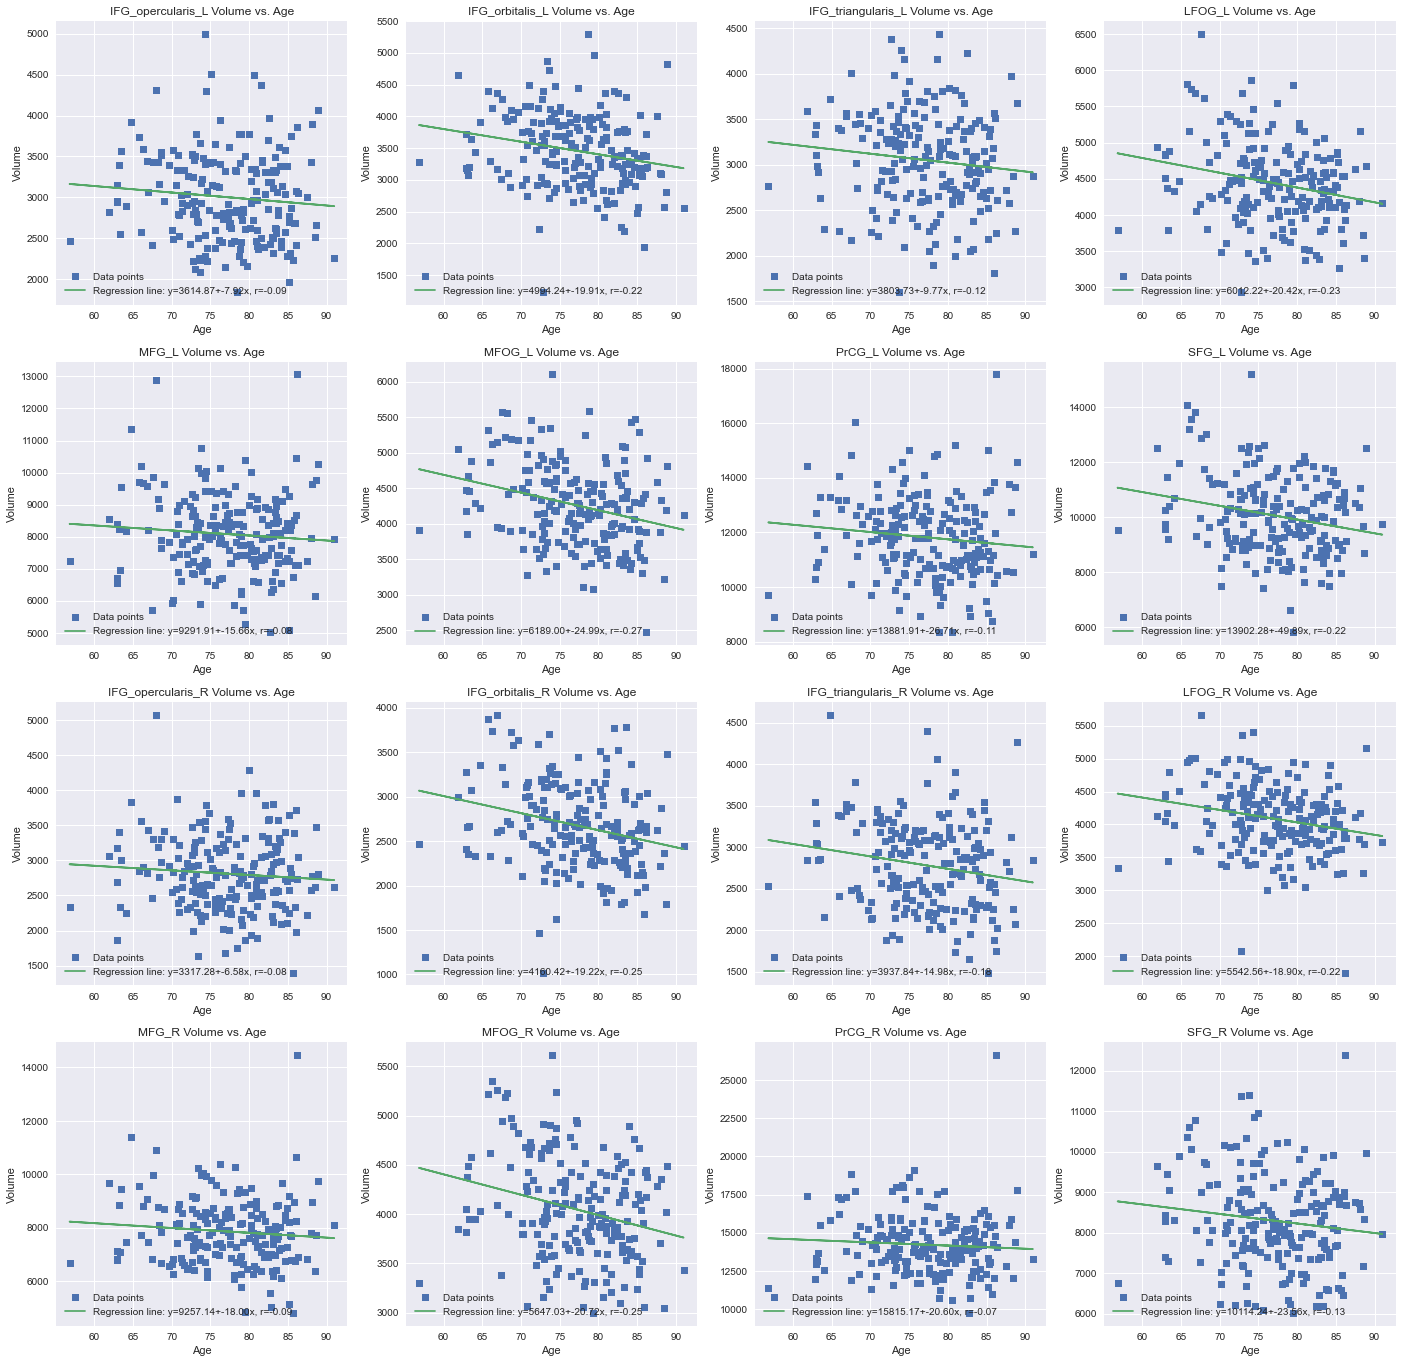

In [38]:
#Linear Regression

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 24))
plt.style.use('seaborn-white')

for i in range(0,16):
    slope, intercept, r, p, stderr = scipy.stats.linregress(dat_h_age['Age'], dat_h_age[rois[i]])
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    axes[i//4,i%4].plot(dat_h_age['Age'], dat_h_age[rois[i]], linewidth=0, marker='s', label='Data points')
    axes[i//4,i%4].plot(dat_h_age['Age'], intercept + slope * dat_h_age['Age'],label=line)
    axes[i//4,i%4].set_xlabel('Age')
    axes[i//4,i%4].set_ylabel('Volume')
    axes[i//4,i%4].set_title(rois[i]+' Volume vs. Age')
    axes[i//4,i%4].legend(facecolor='white',loc='lower left')
    

plt.show()

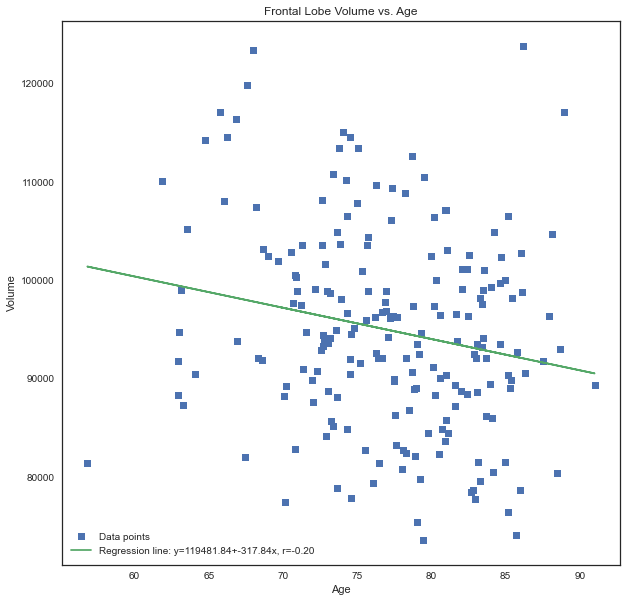

In [39]:
#Linear Regression (Frontal Lobe vs. Age)

slope, intercept, r, p, stderr = scipy.stats.linregress(dat_h_age['Age'], dat_h_age['Total_Frontal Lobe'])
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(dat_h_age['Age'], dat_h_age['Total_Frontal Lobe'], linewidth=0, marker='s', label='Data points')
ax.plot(dat_h_age['Age'], intercept + slope * dat_h_age['Age'], label=line)
ax.set_xlabel('Age')
ax.set_ylabel('Volume')
ax.set_title('Frontal Lobe Volume vs. Age')
ax.legend(facecolor='white',loc='lower left')

plt.show()


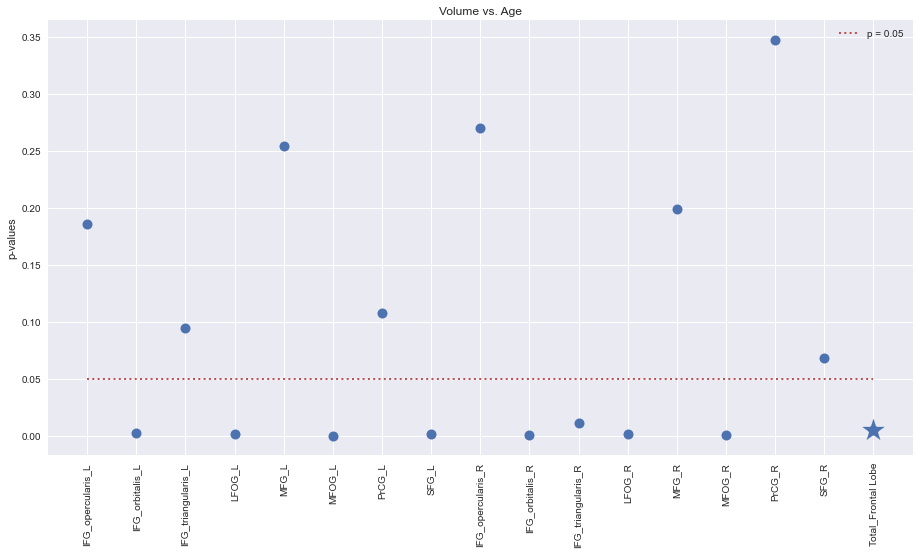

In [40]:
# plot p-values

rois_h_age = rois.copy()
rois_h_age.append('Total_Frontal Lobe')

list_pvalue = [] #create a list of p-values
for area in rois_h_age:
    (r, p) = scipy.stats.pearsonr(dat_h_age['Age'], dat_h_age[area])
    list_pvalue.append(p)
df_h_age = pd.DataFrame({'p-values': list_pvalue}, index=rois_h_age)

plt.style.use('seaborn')
plt.figure(figsize=(15.5,8))
plt.plot(df_h_age['p-values'],'.', label='_nolegend_',markersize = 20)
plt.scatter(16,df_h_age.loc['Total_Frontal Lobe'],s = 2*2**8, marker='*') #mark the Total one
plt.plot(np.arange(df_h_age.shape[0]), np.full(df_h_age.shape[0],0.05), 'r:', linewidth=2)
plt.xticks(rotation='vertical')
plt.ylabel('p-values')
plt.legend(['p = 0.05'], loc='upper right')
plt.title('Volume vs. Age');

## MRI Cloud Data
- z-score Barcodes
- Bar Plot

In [41]:
# read the MRI Cloud data from Excel
mri = pd.read_excel('MRICloud_volume_rois.xlsx',index_col=0)
#mri

**z-score Barcodes**

In [42]:
# Calculate z-score for MRI Cloud data using ADNI Control Mean and STD
mri_zscore = (mri - control_mean) / control_std
#mri_zscore

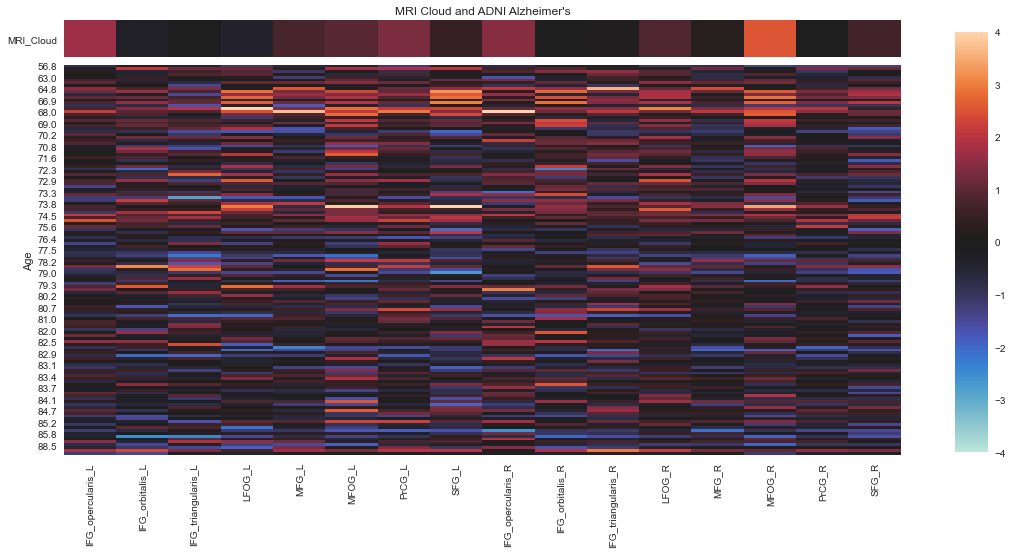

In [43]:
# ADNI AD vs MRI Cloud
fig, axn = plt.subplots(10,1, figsize=(15,8))
cbar_ax = fig.add_axes([0.95, 0.13, 0.03, .73])

plt.subplot(10,1,1)
sns.heatmap(mri_zscore, xticklabels=False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)
plt.title('MRI Cloud and ADNI Alzheimer\'s');

plt.subplot(10,1,(2,10))
sns.heatmap(age_sorted_zscores_ad, vmin=-4, vmax=4, center=0, cbar_ax=cbar_ax)
plt.yticks(rotation=0);

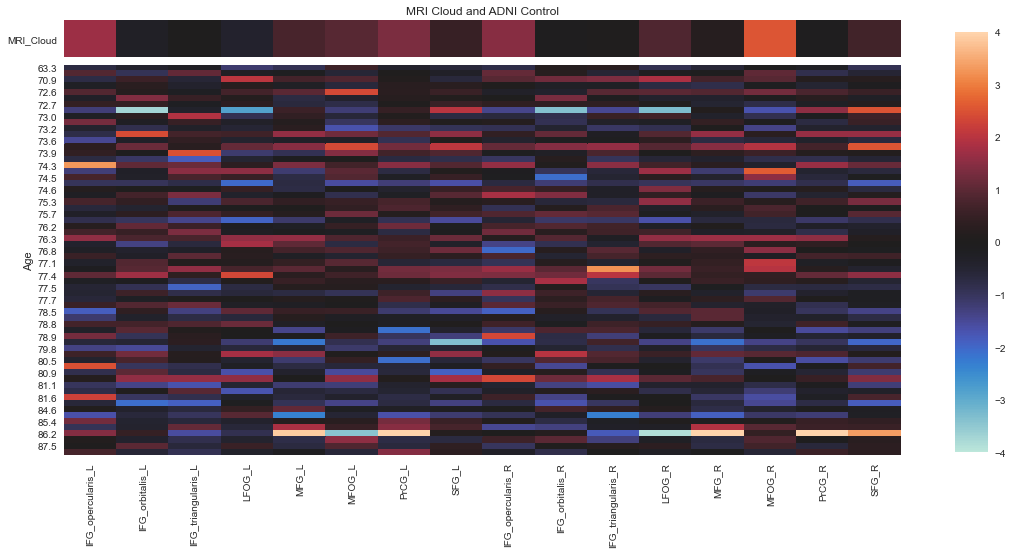

In [44]:
# ADNI Control vs MRI Cloud
fig, axn = plt.subplots(10,1, figsize=(15,8))
cbar_ax = fig.add_axes([0.95, 0.13, 0.03, .73])

plt.subplot(10,1,1)
sns.heatmap(mri_zscore, xticklabels=False, vmin=-4, vmax=4, center=0, cbar=False)
plt.yticks(rotation=0)
plt.title('MRI Cloud and ADNI Control');

plt.subplot(10,1,(2,10))
sns.heatmap(age_sorted_zscores_control, vmin=-4, vmax=4, center=0, cbar_ax=cbar_ax)
plt.yticks(rotation=0);

**Bar Plot**

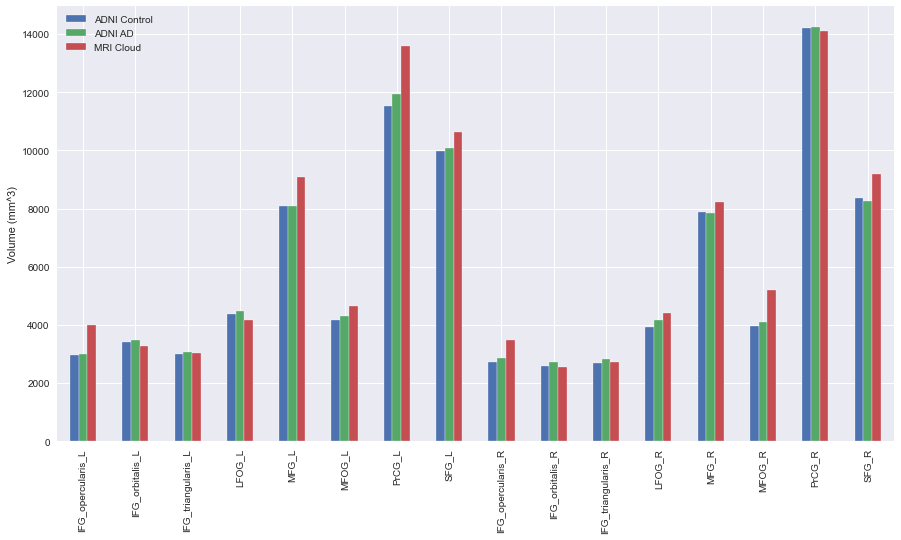

In [45]:
# bar plot
combo = pd.DataFrame({'ADNI Control': control_mean.to_numpy(),
            'ADNI AD': ad_volume.mean().to_numpy(),
            'MRI Cloud': mri.to_numpy()[0]}, index=mri.columns)


combo.plot.bar(rot=90,figsize=(15,8))
plt.legend()
plt.ylabel('Volume (mm^3)');